# コードのテスト
## plot_log.py, plot_12task_log.pyの関数について

In [1]:
import os
gpu_num = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

# モジュールimport
import os, sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
path = os.path.join(current_dir, '../../')
sys.path.append(path)
from dataset import plot_log, prepare_data, util, plot_12task_log
from transformer import get_train_valid_test
from model import define_model, multi_loss, my_callback, my_metric
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam

import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

sys.path.append(r'/home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator')
from random_eraser import get_random_eraser

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file


Using TensorFlow backend.
/home/tmp10014/.conda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file


In [2]:
%%time
num_classes=12
train_batch_size=68#17
valid_batch_size=37#6
shape=[100, 100, 3]
epochs=3
out_dir='output_test/100x100'
gpu_count=len(gpu_num.split(','))

# ラベル情報などが書いたcsvファイル（tox21_compoundData.csv）
csv_path = r'../../storage/tox21_compoundData.csv'
# IDにファイルのフルパスつける
img_dir = r'../../storage/img/Wash/100x100/'
# 画像ファイルのサフィックス
img_suffix = r'_000.jpg'
# 欠損値を-1に置換したtox21_compoundData.csvのデータフレーム
df = prepare_data.make_label_df(csv_path, img_dir, img_suffix=img_suffix)
# Tox21の画像のパスとラベル(y_train,y_valid,y_test)を取得する
train_files, validation_files, test_files, y_train, y_valid, y_test = prepare_data.make_train_val_test(df)

horizontal_flip=True
vertical_flip=True
rotation_range=60
zoom_range=[0.5, 1.9]
shear_range=0.2

d_cls = get_train_valid_test.LabeledDataset(shape, train_batch_size, valid_batch_size)
d_cls.load_train_as_image(train_files, y_train)
d_cls.load_validation_as_image(validation_files, y_valid)
d_cls.load_test_as_image(test_files, y_test)

# ImageDataGenerator のオプションを辞書型で詰める
# get_random_eraserでd_clsの値使うのでここで宣言しないとエラーになる
IDG_options={'horizontal_flip': horizontal_flip
             , 'vertical_flip': vertical_flip
             , 'rotation_range': rotation_range
             , 'zoom_range': zoom_range
             , 'shear_range': shear_range
             , 'preprocessing_function': get_random_eraser(v_l=np.min(d_cls.X_train), v_h=np.max(d_cls.X_train))
            }

d_cls.create_generator(IDG_options=IDG_options)

# 12の出力（task）をだすgeneratorにする
generator_multi_train = get_train_valid_test.generator_12output(d_cls.train_gen)
generator_multi_valid = get_train_valid_test.generator_12output(d_cls.valid_gen)

training_set_y.shape: (11764, 12)
validation_set_y.shape: (296, 12)
test_set_y.shape: (647, 12)
----- train_ImageDataGenerator -----
use_mixup: False
IDG_options: {'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 60, 'zoom_range': [0.5, 1.9], 'shear_range': 0.2, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f2f4f5aa488>}
CPU times: user 7.81 s, sys: 2.49 s, total: 10.3 s
Wall time: 27.2 s


## model.fit_generator(No_branch)

In [3]:
# callback
check_monitor='val_loss' # val_loss最少になるモデルを保存する
early_monitor='val_loss' # val_lossが100エポック更新されなければ学習停止する
early_stopping_pati=100
plateau_monitor='val_loss' # val_lossが100エポック更新されなければ学習率0.9倍
plateau_pati=100
plateau_factor=0.9 # plateau_factor=1.0 はエラーになる

cb = []
if gpu_count > 1:
    # マルチGPUでModelCheckpoint使うためのコールバック
    weight_dir = os.path.join(out_dir, 'model_weight')
    os.makedirs(weight_dir, exist_ok=True)
    cb.append(my_callback.MyCheckPoint(orig_model, weight_dir))
    
    # batch_sizeは並列で処理を行うために元々のbatch_sizeをGPUの数だけ掛ける
    train_batch_size = train_batch_size * gpu_count
    valid_batch_size = valid_batch_size * gpu_count
else:
    cb.append(keras.callbacks.TerminateOnNaN())
    #cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(out_dir, 'test_model.h5'), monitor=check_monitor, save_best_only=True, verbose=1))#, monitor='val_acc'
    cb.append(keras.callbacks.EarlyStopping(monitor=early_monitor, patience=early_stopping_pati, verbose=1))
    # ReduceLROnPlateau つけないと学習率csvファイルに記録されない
    plateau = keras.callbacks.ReduceLROnPlateau(
                monitor=plateau_monitor, # モデルの検証データセットでの損失値を監視
                factor=plateau_factor, # コールバックが起動したら学習率をplateau_factor掛ける
                patience=plateau_pati # 検証データでの損失値がplateauエポックにわたって改善しなかった場合はコールバックを起動
                )
    cb.append(plateau)
    
    base_lr = 0.1 * train_batch_size / 128  # adamとかなら1e-3くらい。SGDなら例えば 0.1 * batch_size / 128 とかくらい。nadamなら0.002*10 ?
    lr_decay_rate = 1 / 3
    lr_steps = 4
    cb.append(keras.callbacks.LearningRateScheduler(lambda ep: float(base_lr * lr_decay_rate ** (ep * lr_steps // epochs))))
    
    # 学習率をエポック増やすごとにコサインカーブのように上げ下げする
    ## 引数なしならlr*0.01されるだけ
    cb.append(my_callback.cosine_annealing())
    
    # callbackで学習率表示
    loss_history = my_callback.LossHistory()
    cb.append(loss_history)
    
cb.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history.tsv'), separator='\t'))
cb.append(my_callback.tsv_logger(os.path.join(out_dir, 'tsv_logger.tsv'), append=True))
print(cb)

[<keras.callbacks.TerminateOnNaN object at 0x7f2f4f2396a0>, <keras.callbacks.EarlyStopping object at 0x7f2f4f239710>, <keras.callbacks.ReduceLROnPlateau object at 0x7f2f4f239748>, <keras.callbacks.LearningRateScheduler object at 0x7f2f4f239780>, <model.my_callback.cosine_annealing.<locals>._CosineAnnealing object at 0x7f2f4f2397b8>, <model.my_callback.LossHistory object at 0x7f2f4f2397f0>, <keras.callbacks.CSVLogger object at 0x7f2f4f239860>, <model.my_callback.tsv_logger.<locals>._TSVLogger object at 0x7f2f4f239898>]


In [4]:
%%time
import copy
cb_new = copy.copy(cb)
choice_model_list=['VGG16']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[1]# [None,1,2,3,4,5]
FCpool='GlobalAveragePooling2D'
Dence_1, Dropout_1, addBatchNorm_1, kernel_initializer_1, l2_rate_1=1024, 0.5, None, 'he_normal', 1e-4
Dence_2, Dropout_2, addBatchNorm_2, kernel_initializer_2, l2_rate_2=512, 0.5, None, 'he_normal', 1e-4
Dence_3, Dropout_3, addBatchNorm_3, kernel_initializer_3, l2_rate_3=256, 0.5, None, 'he_normal', 1e-4
Dence_4, Dropout_4, addBatchNorm_4, kernel_initializer_4, l2_rate_4=128, 0.5, None, 'he_normal', 1e-4
Dence_5, Dropout_5, addBatchNorm_5, kernel_initializer_5, l2_rate_5=64, 0.5, None, 'he_normal', 1e-4
pred_kernel_initializer='zeros'
pred_l2_rate=1e-4
activation_list=['sigmoid']# ['sigmoid','softmax']
trainable='all'
skip_bn=True
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt, decay=0.0)
                lr_metric = my_metric.get_lr_metric(optim)# コールバックで下げたlrは表示されない。あくまでそのエポックの初期学習率をエポックごとに表示する
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy, lr_metric])
                
            model.fit_generator(d_cls.train_gen
                    , steps_per_epoch=d_cls.train_steps_per_epoch()
                    , epochs=epochs
                    , validation_data=d_cls.valid_gen
                    , validation_steps=d_cls.valid_steps_per_epoch()
                    , callbacks=cb_new
                    , verbose=1)


###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 12
choice_model trainable = VGG16 all
FCnum = 1
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.5 None he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
Epoch 1/3
172/173 [============================>.] - ETA: 0s - loss: 0.3378 - acc: 0.1120 - binary_accuracy: 0.6459 - masked_accuracy: 0.9271 - lr: 0.0075
lr: 0.1
173/173 [==============================] - 94s 541ms/step - loss: 0.3376 - acc: 0.1116 - binary_accuracy: 0.6461 - masked_accuracy: 0.9271 - lr: 0.0075 - val_loss: 0.3918 - val_acc: 0.0473 - val_binary_accuracy: 0.8088 - val_masked_accuracy: 0.9178 - val_lr: 0.0075
Epoch 2/3
172/173 [============================>.] - ETA: 0s - loss: 0.3220 - acc: 0.1057 - binary_accuracy: 0.6461 - masked_accuracy: 0.9273 - lr: 0.0026
lr: 0.1
173/173 [==============================] - 89s 516ms/step - loss: 0.3220 - acc: 0.1057 - binary_accuracy: 0.6461 - masked_accuracy: 0.9273 - lr: 0.0026 - val_loss: 0.3897 - val_acc: 0.0439 - val_binary_accura

## plot_log.plot_results

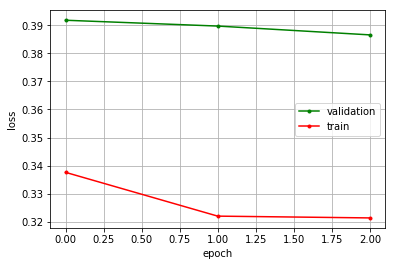

<Figure size 432x288 with 0 Axes>

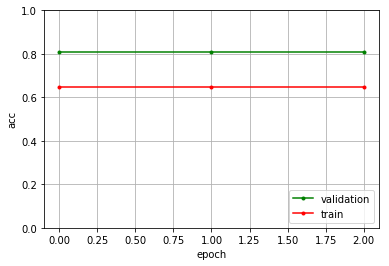

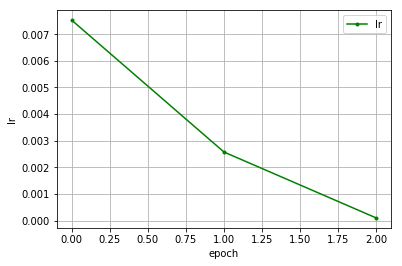

<Figure size 432x288 with 0 Axes>

In [5]:
%matplotlib inline
plot_log.plot_results(out_dir, os.path.join(out_dir, 'history.tsv'))

### 同じcallback 使いまわしているため'tsv_logger.tsv' は追記されエラーになる

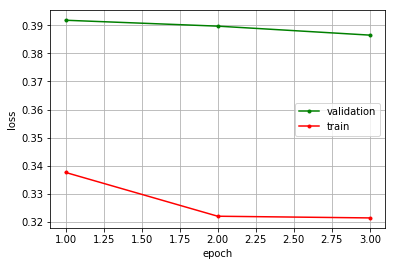

<Figure size 432x288 with 0 Axes>

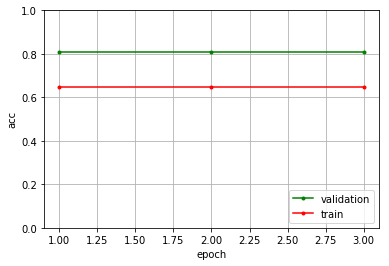

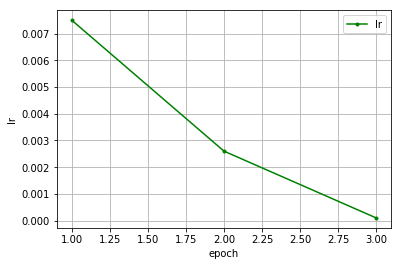

<Figure size 432x288 with 0 Axes>

In [7]:
%matplotlib inline
plot_log.plot_results(out_dir, os.path.join(out_dir, 'tsv_logger.tsv'))

## model.fit_generator(12branch)
- ニューラルネットワークを分岐させてMulti-task learningのときに使うもの

In [8]:
# callback
check_monitor='val_loss' # val_loss最少になるモデルを保存する
early_monitor='val_loss' # val_lossが100エポック更新されなければ学習停止する
early_stopping_pati=100
plateau_monitor='val_loss' # val_lossが100エポック更新されなければ学習率0.9倍
plateau_pati=100
plateau_factor=0.9 # plateau_factor=1.0 はエラーになる

cb = []
if gpu_count > 1:
    # マルチGPUでModelCheckpoint使うためのコールバック
    weight_dir = os.path.join(out_dir, 'model_weight')
    os.makedirs(weight_dir, exist_ok=True)
    cb.append(my_callback.MyCheckPoint(orig_model, weight_dir))
    
    # batch_sizeは並列で処理を行うために元々のbatch_sizeをGPUの数だけ掛ける
    train_batch_size = train_batch_size * gpu_count
    valid_batch_size = valid_batch_size * gpu_count
else:
    cb.append(keras.callbacks.TerminateOnNaN())
    #cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(out_dir, 'test_model.h5'), monitor=check_monitor, save_best_only=True, verbose=1))#, monitor='val_acc'
    cb.append(keras.callbacks.EarlyStopping(monitor=early_monitor, patience=early_stopping_pati, verbose=1))
    # ReduceLROnPlateau つけないと学習率csvファイルに記録されない
    plateau = keras.callbacks.ReduceLROnPlateau(
                monitor=plateau_monitor, # モデルの検証データセットでの損失値を監視
                factor=plateau_factor, # コールバックが起動したら学習率をplateau_factor掛ける
                patience=plateau_pati # 検証データでの損失値がplateauエポックにわたって改善しなかった場合はコールバックを起動
                )
    cb.append(plateau)
    
    base_lr = 0.1 * train_batch_size / 128  # adamとかなら1e-3くらい。SGDなら例えば 0.1 * batch_size / 128 とかくらい。nadamなら0.002*10 ?
    lr_decay_rate = 1 / 3
    lr_steps = 4
    cb.append(keras.callbacks.LearningRateScheduler(lambda ep: float(base_lr * lr_decay_rate ** (ep * lr_steps // epochs))))
    
    # 学習率をエポック増やすごとにコサインカーブのように上げ下げする
    ## 引数なしならlr*0.01されるだけ
    cb.append(my_callback.cosine_annealing())
    
    # callbackで学習率表示
    loss_history = my_callback.LossHistory()
    cb.append(loss_history)
    
cb.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history.tsv'), separator='\t'))
cb.append(my_callback.tsv_logger(os.path.join(out_dir, 'tsv_logger.tsv'), append=True))
print(cb)

[<keras.callbacks.TerminateOnNaN object at 0x7f2ef593f7f0>, <keras.callbacks.EarlyStopping object at 0x7f2ef593f668>, <keras.callbacks.ReduceLROnPlateau object at 0x7f2ef593f6a0>, <keras.callbacks.LearningRateScheduler object at 0x7f2ef593f898>, <model.my_callback.cosine_annealing.<locals>._CosineAnnealing object at 0x7f2ef593f8d0>, <model.my_callback.LossHistory object at 0x7f2ef593f4a8>, <keras.callbacks.CSVLogger object at 0x7f2ef593f6d8>, <model.my_callback.tsv_logger.<locals>._TSVLogger object at 0x7f2ef593f438>]


In [11]:
%%time
import copy
cb_new = copy.copy(cb)
cb_new.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(out_dir, 'test_model_12branch.h5'), monitor=check_monitor, save_best_only=True, verbose=1))

choice_model_list=['Xception']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[None]# [None,1,2,3,4,5]
FCpool='GlobalAveragePooling2D'
Dence_1, Dropout_1, addBatchNorm_1, kernel_initializer_1, l2_rate_1=1024, 0.5, None, 'he_normal', 1e-4
Dence_2, Dropout_2, addBatchNorm_2, kernel_initializer_2, l2_rate_2=512, 0.5, None, 'he_normal', 1e-4
Dence_3, Dropout_3, addBatchNorm_3, kernel_initializer_3, l2_rate_3=256, 0.5, None, 'he_normal', 1e-4
Dence_4, Dropout_4, addBatchNorm_4, kernel_initializer_4, l2_rate_4=128, 0.5, None, 'he_normal', 1e-4
Dence_5, Dropout_5, addBatchNorm_5, kernel_initializer_5, l2_rate_5=64, 0.5, None, 'he_normal', 1e-4
pred_kernel_initializer='zeros'
pred_l2_rate=1e-4
activation_list=['sigmoid']# ['sigmoid','softmax']
trainable='all'
gpu_count=len(gpu_num.split(','))
skip_bn=True
opt_list=['nadam']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_12branch_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt, decay=0.0)
                lr_metric = my_metric.get_lr_metric(optim)
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy, lr_metric])
                
                
                model.fit_generator(generator_multi_train
                    , steps_per_epoch=d_cls.train_steps_per_epoch()
                    , epochs=epochs
                    , validation_data=generator_multi_valid
                    , validation_steps=d_cls.valid_steps_per_epoch()
                    , callbacks=cb_new
                    , verbose=1)


###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 12
choice_model trainable = Xception all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
---- choice_optim = nadam ----
nadam_lr nadam_schedule_decay beta_1 beta_2 = 0.002 0.004 0.9 0.999
Epoch 1/3
172/173 [============================>.] - ETA: 0s - loss: 2.0936 - task0_pred_loss: 0.2508 - task1_pred_loss: 0.1326 - task2_pred_loss: 0.1124 - task3_pred_loss: 0.1243 - task4_pred_loss: 0.2368 - task5_pred_loss: 0.1506 - task6_pred_loss: 0.0988 - task7_pred_loss: 0.2589 - task8_pred_loss: 0.1332 - ta

172/173 [============================>.] - ETA: 0s - loss: 1.9198 - task0_pred_loss: 0.2360 - task1_pred_loss: 0.1162 - task2_pred_loss: 0.0950 - task3_pred_loss: 0.1135 - task4_pred_loss: 0.2257 - task5_pred_loss: 0.1379 - task6_pred_loss: 0.0866 - task7_pred_loss: 0.2480 - task8_pred_loss: 0.1194 - task9_pred_loss: 0.1390 - task10_pred_loss: 0.2419 - task11_pred_loss: 0.1603 - task0_pred_acc: 0.6136 - task0_pred_binary_accuracy: 0.6136 - task0_pred_masked_accuracy: 0.8834 - task0_pred_lr: 5.1500e-04 - task1_pred_acc: 0.7636 - task1_pred_binary_accuracy: 0.7636 - task1_pred_masked_accuracy: 0.9587 - task1_pred_lr: 5.1500e-04 - task2_pred_acc: 0.7061 - task2_pred_binary_accuracy: 0.7061 - task2_pred_masked_accuracy: 0.9642 - task2_pred_lr: 5.1500e-04 - task3_pred_acc: 0.5834 - task3_pred_binary_accuracy: 0.5834 - task3_pred_masked_accuracy: 0.9496 - task3_pred_lr: 5.1500e-04 - task4_pred_acc: 0.5756 - task4_pred_binary_accuracy: 0.5756 - task4_pred_masked_accuracy: 0.8778 - task4_pred_

CPU times: user 6min 46s, sys: 35.8 s, total: 7min 22s
Wall time: 5min 44s


## plot_12task_log.plot_results

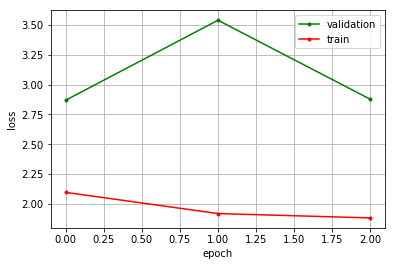

<Figure size 432x288 with 0 Axes>

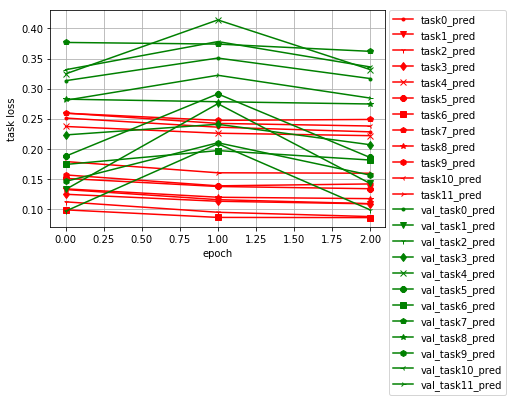

<Figure size 432x288 with 0 Axes>

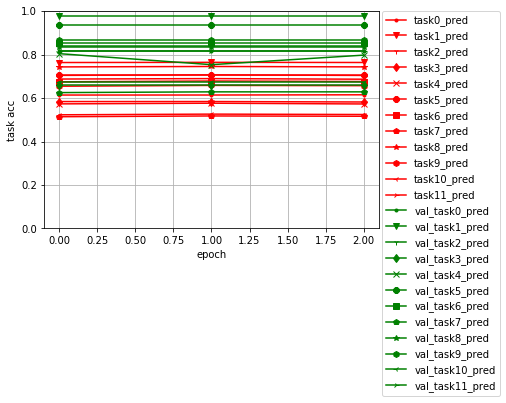

<Figure size 432x288 with 0 Axes>

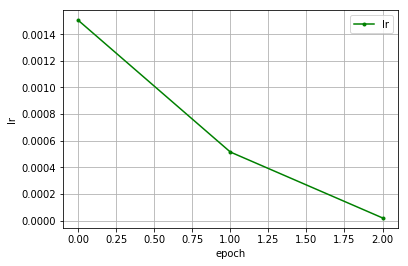

<Figure size 432x288 with 0 Axes>

In [12]:
%matplotlib inline
plot_12task_log.plot_results(out_dir, os.path.join(out_dir, 'history.tsv'))

### 同じcallback 使いまわしているため'tsv_logger.tsv' は追記されエラーになる

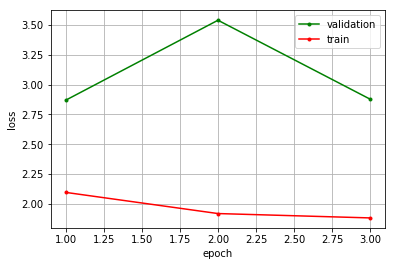

<Figure size 432x288 with 0 Axes>

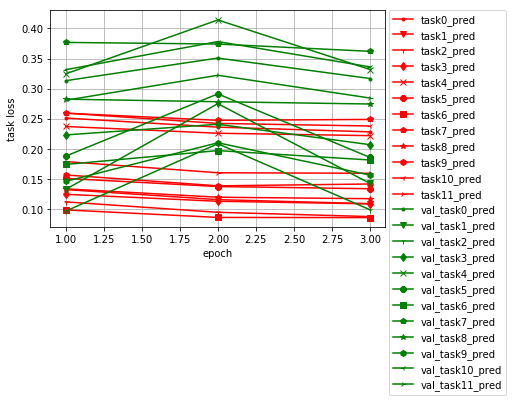

<Figure size 432x288 with 0 Axes>

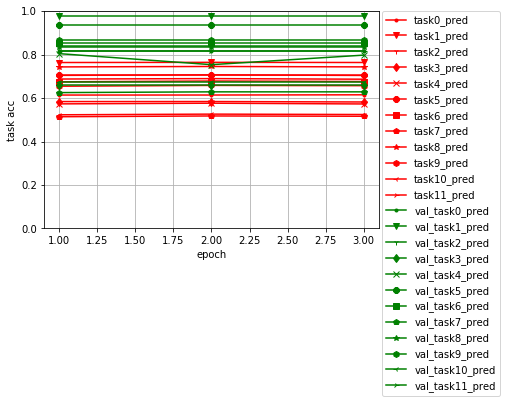

<Figure size 432x288 with 0 Axes>

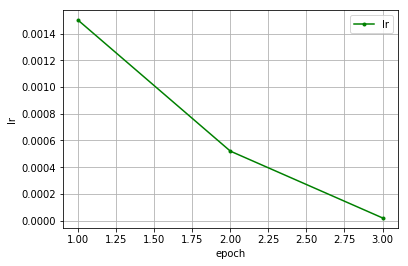

<Figure size 432x288 with 0 Axes>

In [14]:
%matplotlib inline
plot_12task_log.plot_results(out_dir, os.path.join(out_dir, 'tsv_logger.tsv'))